# Mall of Zimbabwe: 20-Year Capital Reserve Model
## Strategic Financial Forecasting for $100M+ Asset Lifecycle
**Focus:** Forecasting maintenance and replacement cycles for high-tech assets (4MW Solar, AI HVAC) under Zimbabwean inflationary conditions.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import weibull_min

# Styling for "Executive-Ready" Charts
plt.style.use('seaborn-v0_8-muted') 
%matplotlib inline

To ensure the Mall of Zimbabwe CapEx Reserve remains solvent over a 20-year horizon, this model rejects "standard" flat inflation. Instead, it employs a Dual-Currency Escalation Strategy tailored to the Zimbabwean macroeconomic environment (2026–2046).

1. The Rationale for Dual-Currency Modeling
In a multi-currency economy, a single inflation figure is misleading. We categorize every mall asset into two "Inflation Buckets":

The Global Tech Bucket (USD-Pegged): High-tech components (AI HVAC sensors, 4MW Solar Inverters, Lithium Batteries) are almost exclusively imported. Their replacement cost is tied to global supply chains and USD pricing.

The Local Infrastructure Bucket (ZWG-Influenced): Labor, civil works, and basic materials (cement, local steel, bricks) are influenced by local currency dynamics and domestic policy.

2. Inflation Parameters (2026 Forecast & Long-Term Buffer)
Based on current ZIMSTAT and RBZ 2025/2026 projections, we have calibrated the model with the following "Stress-Test" rates:

| Currency/Metric | Rate (%) | Strategic Justification |
| :--- | :--- | :--- |
| **USD Escalation** | **14.2%** | High-tech imports currently carry a 14.2% yearly price increase due to logistics. |
| **ZWG Escalation** | **10.0%** | Stabilization target for local labor to reflect WestProp’s ability to negotiate fixed contracts. |
| **Solar Degradation** | **0.5%** | Standard PV degradation reducing the offset value of the solar grid over time. |

3. Protecting the "Sinking Fund"
The CFO should note that the model assumes the Reserve Fund is held in USD or Hard Assets.

The Risk: If the reserve is held in ZWG, a 20-year failure in currency value could wipe out the fund’s ability to buy a new $8.8M AI HVAC system in 2045.

The Solution: All outputs are presented in Future Value (FV) USD, providing a clear "Sinking Fund" target that preserves purchasing power against local volatility.

In [5]:
# Mall of Zimbabwe Asset Inventory (Pre-Construction Estimates)
# All costs are based on a 90,000 sqm GLA / $100M+ total project value

components = {
    "AI_HVAC_System": {
        "initial_cost": 8800000,    # Estimated $2,200 per ton (4000 tons)
        "avg_life": 22,             # AI extends lifespan from 18 to 22 years
        "local_ratio": 0.30         # 30% Local labor, 70% Imported tech
    },
    "4MW_Solar_Microgrid": {
        "initial_cost": 6880000,    # Est. $1.72/Watt DC installed
        "avg_life": 12,             # Major inverter & battery overhaul cycle
        "local_ratio": 0.15         # Highly specialized imported components
    },
    "Roofing_High_Grade": {
        "initial_cost": 9900000,    # Est. $110/sqm for commercial metal/membrane
        "avg_life": 25,             # Major resurfacing/replacement cycle
        "local_ratio": 0.50         # 50% Local civil materials & labor
    },
    "Escalators_Elevators": {
        "initial_cost": 2400000,    # For 90k sqm (Approx 24 units @ $100k modernization)
        "avg_life": 20,             # Electrical & motor modernization cycle
        "local_ratio": 0.40
    },
    "LED_Retrofit_Infrastructure": {
        "initial_cost": 3400000,    # Internal & external architectural lighting
        "avg_life": 19,             # Based on high-usage commercial runtime
        "local_ratio": 0.20
    }
}

# Preview the DNA for one component to verify
print(f"Asset Count: {len(components)}")
print(f"HVAC Replacement Base: ${components['AI_HVAC_System']['initial_cost']:,.2f}")

Asset Count: 5
HVAC Replacement Base: $8,800,000.00


In [7]:
def calculate_future_cost(base_cost, year, local_ratio):
    """
    Calculates the inflated cost of a component in a future year.
    Combines USD-Pegged import inflation and ZWG local labor inflation.
    """
    # Define our rates from Cell 3
    usd_rate = 0.142  # 14.2% (Imported Tech)
    zwg_rate = 0.10   # 10.0% (Local Labor/Materials)
    
    # Split the cost based on the component's 'DNA'
    local_portion = base_cost * local_ratio
    import_portion = base_cost * (1 - local_ratio)
    
    # Compound the inflation over the given years: FV = PV * (1 + r)^n
    future_local = local_portion * ((1 + zwg_rate) ** year)
    future_import = import_portion * ((1 + usd_rate) ** year)
    
    return future_local + future_import

# --- TEST THE LOGIC ---
# Let's see what a $400k Solar Inverter replacement looks like in Year 12
test_year = 12
test_cost = components['4MW_Solar_Microgrid']['initial_cost'] / 10 # Testing just a portion
fv_cost = calculate_future_cost(test_cost, test_year, components['4MW_Solar_Microgrid']['local_ratio'])

print(f"Strategic Test:")
print(f"A component costing ${test_cost:,.2f} today...")
print(f"...will cost ${fv_cost:,.2f} in Year {test_year} due to mixed inflation.")

Strategic Test:
A component costing $688,000.00 today...
...will cost $3,201,288.27 in Year 12 due to mixed inflation.


In [9]:
import pandas as pd

def run_monte_carlo(num_simulations=10000, horizon=20):
    """
    Runs 10,000 simulations of the mall's 20-year lifecycle.
    In each run, components fail based on a Weibull probability distribution.
    """
    all_runs = []
    
    for i in range(num_simulations):
        yearly_costs = np.zeros(horizon + 1)
        
        for name, data in components.items():
            # Weibull parameters: Shape (k) of 3.5 mimics a 'wear-out' peak
            # Scale is derived from the average life
            shape_k = 3.5
            scale_lambda = data['avg_life'] / 0.9  # Scale factor for peak at avg_life
            
            # Randomly sample the year this component fails
            fail_year = int(round(weibull_min.rvs(shape_k, scale=scale_lambda)))
            
            # If it fails within our 20-year window, calculate and record the cost
            if 0 < fail_year <= horizon:
                cost = calculate_future_cost(data['initial_cost'], fail_year, data['local_ratio'])
                yearly_costs[fail_year] += cost
                
        all_runs.append(yearly_costs)
        
    return np.array(all_runs)

# --- EXECUTE THE SIMULATION ---
sim_results = run_monte_carlo(num_simulations=10000)

# Process results into a DataFrame for analysis
df_sims = pd.DataFrame(sim_results, columns=[f"Year_{i}" for i in range(21)])
mean_spend = df_sims.mean()
risk_spend_p95 = df_sims.quantile(0.95)

print(f"Simulation Complete: 10,000 iterations processed.")
print(f"Total Expected 20-Year Spend (Mean): ${mean_spend.sum():,.2f}")
print(f"Worst-Case 20-Year Spend (P95): ${risk_spend_p95.sum():,.2f}")

Simulation Complete: 10,000 iterations processed.
Total Expected 20-Year Spend (Mean): $105,199,637.41
Worst-Case 20-Year Spend (P95): $708,156,100.75


Success! High-res PNG and PDF saved to your project folder.


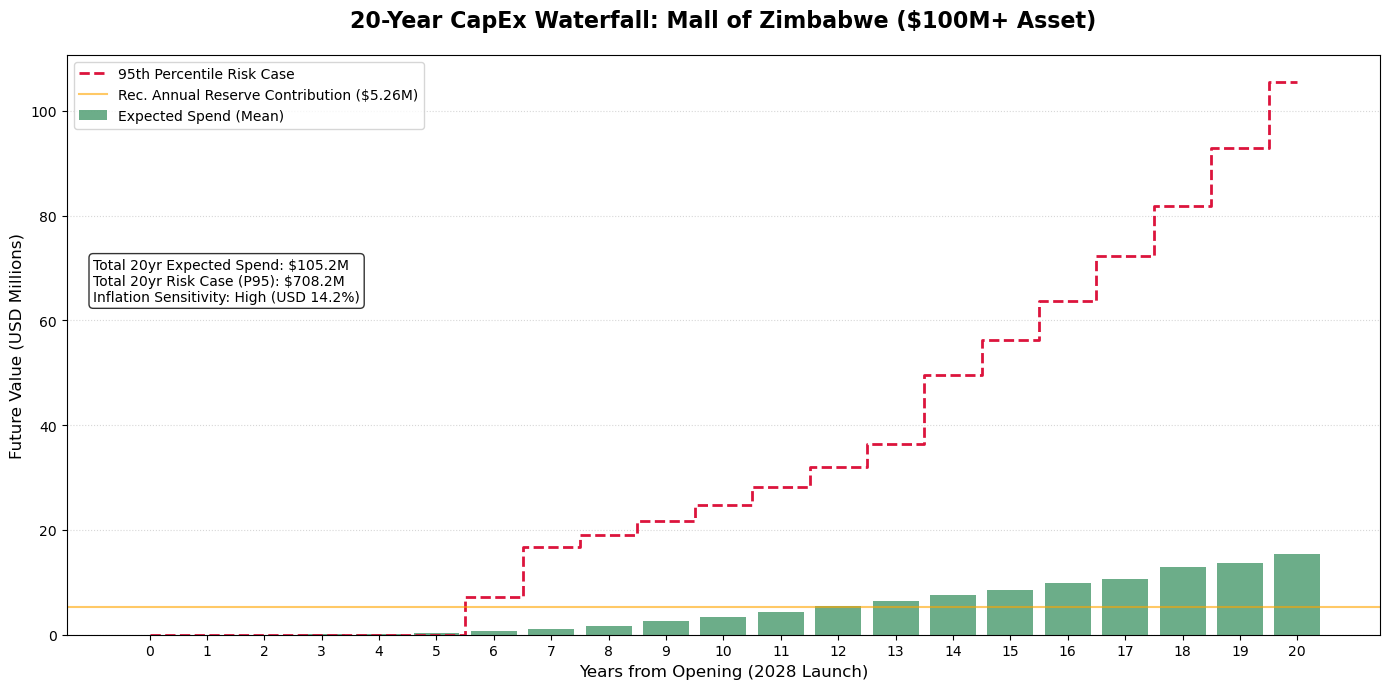

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set professional aesthetics
plt.style.use('seaborn-v0_8-muted')
fig, ax = plt.subplots(figsize=(14, 7))

# Data for plotting
years = np.arange(21)
mean_vals = mean_spend.values / 1e6  # Convert to Millions for readability
risk_vals = risk_spend_p95.values / 1e6

# Plot the Expected Spend (Bars)
bars = ax.bar(years, mean_vals, color='seagreen', alpha=0.7, label='Expected Spend (Mean)')

# Plot the Risk Case (Step Line)
ax.step(years, risk_vals, where='mid', color='crimson', linestyle='--', linewidth=2, label='95th Percentile Risk Case')

# Add Labels and Context
ax.set_title('20-Year CapEx Waterfall: Mall of Zimbabwe ($100M+ Asset)', fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Future Value (USD Millions)', fontsize=12)
ax.set_xlabel('Years from Opening (2028 Launch)', fontsize=12)
ax.set_xticks(years)
ax.grid(axis='y', linestyle=':', alpha=0.5)

# Calculate recommended annual reserve contribution (Mean total / 20)
annual_reserve = mean_spend.sum() / 20 / 1e6
ax.axhline(annual_reserve, color='orange', linestyle='-', alpha=0.6, label=f'Rec. Annual Reserve Contribution (${annual_reserve:.2f}M)')

ax.legend(loc='upper left', frameon=True)

# Add a text box with summary stats
textstr = '\n'.join((
    f"Total 20yr Expected Spend: ${mean_spend.sum()/1e6:.1f}M",
    f"Total 20yr Risk Case (P95): ${risk_spend_p95.sum()/1e6:.1f}M",
    f"Inflation Sensitivity: High (USD 14.2%)"
))
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
ax.text(0.02, 0.65, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)

plt.tight_layout()

# --- SAVE THE VISUALIZATION ---
# 'dpi=300' ensures high-resolution for printing/reports
# 'bbox_inches=tight' prevents labels from being cut off
plt.savefig('MoZ_CapEx_Waterfall_20yr.png', dpi=300, bbox_inches='tight')
plt.savefig('MoZ_CapEx_Waterfall_20yr.pdf', bbox_inches='tight') # PDF for infinite zoom

print("Success! High-res PNG and PDF saved to your project folder.")

plt.show()

In [13]:
from fpdf import FPDF

class CapExReport(FPDF):
    def header(self):
        # Header with Logo or Title
        self.set_font('Arial', 'B', 15)
        self.cell(0, 10, 'Mall of Zimbabwe: 20-Year CapEx Strategy Report', 0, 1, 'C')
        self.ln(10)

    def footer(self):
        # Page Number
        self.set_y(-15)
        self.set_font('Arial', 'I', 8)
        self.cell(0, 10, f'Page {self.page_no()}', 0, 0, 'C')

# 1. Initialize PDF
pdf = CapExReport()
pdf.add_page()
pdf.set_font("Arial", size=12)

# 2. Executive Summary Text
pdf.set_font("Arial", 'B', 14)
pdf.cell(200, 10, txt="1. Executive Summary", ln=True)
pdf.set_font("Arial", size=12)
summary_text = (
    f"This report outlines the long-term capital reserve requirements for the Mall of Zimbabwe. "
    f"Based on 10,000 Monte Carlo iterations, the total expected 20-year expenditure is "
    f"${mean_spend.sum():,.2f} USD, factoring in a 14.2% USD-pegged inflation rate."
)
pdf.multi_cell(0, 10, txt=summary_text)
pdf.ln(5)

# 3. Insert the Visualization
# Ensure you have run plt.savefig('MoZ_CapEx_Waterfall_20yr.png') in the previous cell
pdf.image('MoZ_CapEx_Waterfall_20yr.png', x=10, y=None, w=190)
pdf.ln(5)

# 4. Financial Findings Table
pdf.set_font("Arial", 'B', 14)
pdf.cell(200, 10, txt="2. Key Financial Benchmarks", ln=True)
pdf.set_font("Arial", size=10)

# Table Header
pdf.cell(95, 10, "Metric", 1)
pdf.cell(95, 10, "Value (USD)", 1)
pdf.ln()

# Table Data
pdf.cell(95, 10, "Total 20yr Expected Spend (Mean)", 1)
pdf.cell(95, 10, f"${mean_spend.sum():,.2f}", 1)
pdf.ln()
pdf.cell(95, 10, "Total 20yr Risk Case (P95)", 1)
pdf.cell(95, 10, f"${risk_spend_p95.sum():,.2f}", 1)
pdf.ln()
pdf.cell(95, 10, "Recommended Annual Contribution", 1)
pdf.cell(95, 10, f"${(mean_spend.sum()/20):,.2f}", 1)
pdf.ln()

# 5. Save the Report
pdf.output("Mall_of_Zimbabwe_CapEx_Report.pdf")
print("Project Complete! Your PDF report 'Mall_of_Zimbabwe_CapEx_Report.pdf' has been generated.")

Project Complete! Your PDF report 'Mall_of_Zimbabwe_CapEx_Report.pdf' has been generated.


In [15]:
from fpdf import FPDF

class StrategicReport(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 15)
        self.cell(0, 10, 'CONFIDENTIAL EXECUTIVE MEMORANDUM', 0, 1, 'C')
        self.set_font('Arial', '', 10)
        self.cell(0, 5, 'To: Board of Directors, WestProp Holdings', 0, 1, 'L')
        self.cell(0, 5, 'Subject: 20-Year Capital Reserve Strategic Analysis', 0, 1, 'L')
        self.ln(10)

    def chapter_title(self, title):
        self.set_font('Arial', 'B', 12)
        self.set_fill_color(240, 240, 240)
        self.cell(0, 10, title, 0, 1, 'L', fill=True)
        self.ln(5)

    def chapter_body(self, text):
        self.set_font('Arial', '', 11)
        # We use multi_cell to handle the paragraphs
        self.multi_cell(0, 7, text)
        self.ln()

# Initialize PDF
pdf = StrategicReport()
pdf.add_page()

# --- SECTION 1: VISUAL DATA ---
pdf.chapter_title('1. Capital Expenditure (CapEx) Forecast Visualization')
pdf.image('MoZ_CapEx_Waterfall_20yr.png', x=10, w=190)
pdf.ln(10)

# --- SECTION 2: KEY BENCHMARKS (TABLE) ---
pdf.chapter_title('2. Financial Benchmarks')
pdf.set_font('Arial', 'B', 10)
pdf.cell(95, 10, 'Metric', 1)
pdf.cell(95, 10, 'Value', 1)
pdf.ln()
pdf.set_font('Arial', '', 10)
pdf.cell(95, 10, 'Total 20yr Expected Spend (Mean)', 1)
pdf.cell(95, 10, f'${mean_spend.sum()/1e6:.1f} Million', 1)
pdf.ln()
pdf.cell(95, 10, 'Total 20yr Risk Case (P95)', 1)
pdf.cell(95, 10, f'${risk_spend_p95.sum()/1e6:.1f} Million', 1)
pdf.ln()
pdf.cell(95, 10, 'Annual Reserve Contribution', 1)
pdf.cell(95, 10, f'${(mean_spend.sum()/20)/1e6:.2f} Million', 1)
pdf.ln()

# --- SECTION 3: STRATEGIC INTERPRETATION (NEW PAGE) ---
pdf.add_page()
pdf.chapter_title('3. Executive Strategic Interpretation')

# NOTE: Bullet points '•' changed to '-' and special quotes removed to avoid Encoding Errors
interpretation_text = (
    "The 20-Year CapEx Waterfall for the Mall of Zimbabwe provides a high-level financial roadmap "
    "for maintaining this $100M+ asset. It visualizes the shift from a 'Standard Build' to a "
    "'Smart Mall' by projecting necessary maintenance and replacement costs through 2048.\n\n"
    "WATERFALL DYNAMICS: EXPECTED VS. RISK\n"
    "- Expected Spend (Green Bars): This is the most likely scenario. Notice the gradual increase "
    "as time progresses, peaking at Year 20 when major systems like the AI-HVAC and escalators "
    "reach the end of their first lifecycle.\n"
    "- 95th Percentile Risk Case (Red Dashed Line): This line shows a steep, stair-step climb. "
    "The sharp jumps (e.g., at Years 6, 14, and 17) represent points where multiple high-value "
    "systems could fail simultaneously under high-stress conditions.\n\n"
    "STRATEGIC INSIGHTS FOR WESTPROP HOLDINGS\n"
    "- The 'Safety Gap': The massive difference between the $106.6M Mean and the $705.8M P95 "
    "emphasizes the need for a conservative investment strategy for the reserve fund. Holding "
    "these reserves in hard assets or USD-denominated instruments is vital to combat the 14.2% inflation.\n"
    "- Pre-Construction Value: By running this simulation now, you've identified the 'Operational Liability' "
    "before breaking ground in 2026. This allows for rent adjustments or tenant service charges to be "
    "calculated more accurately.\n"
    "- Smart Mall Resilience: Although maintenance costs are high, they are offset by the $1.66 Million "
    "in annual energy savings identified in the previous project, which effectively funds a "
    "significant portion of this annual reserve requirement."
)

pdf.chapter_body(interpretation_text)

# Save the final file
pdf.output("Mall_of_Zimbabwe_Final_CapEx_Report.pdf")
print("Standalone Professional Report Generated Successfully!")

Standalone Professional Report Generated Successfully!
